In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision
import kornia

In [2]:
dataset = torchvision.datasets.ImageNet("/workspace/data/datasets/imagenet/", 
                                        split="val", 
                                        transform=torchvision.transforms.Compose(
                                            [
                                                torchvision.transforms.Resize(256), 
                                                torchvision.transforms.CenterCrop(224), 
                                                torchvision.transforms.ToTensor()
                                            ]
                                        )
                                       )

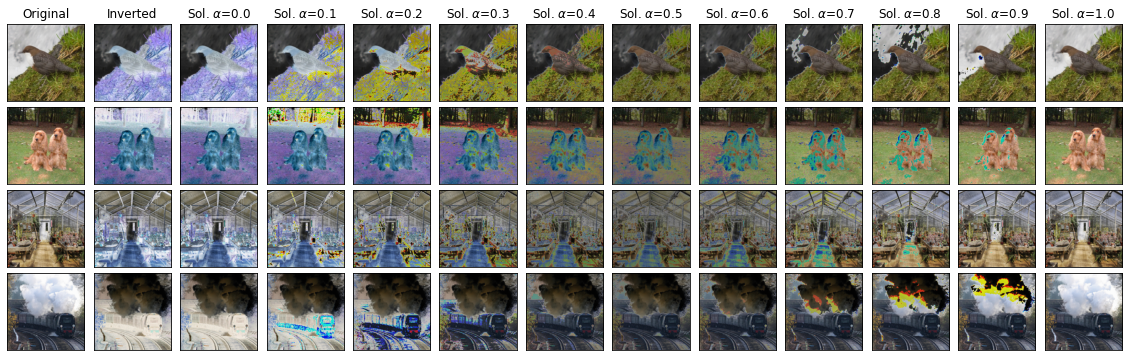

In [3]:
ids = [1003, 11003, 29005, 41003]
alphas = [None, "Invert", *np.arange(0, 1.00001, 0.1)]

fig, axes = plt.subplots(len(ids), len(alphas), figsize=(20, 6))
for ax_col, idx in zip(axes, ids):
    for ax, alpha in zip(ax_col, alphas):
        x, y = dataset[idx][0].unsqueeze(0), torch.tensor([dataset[idx][1]])

        if alpha == None:
            x_aug = x
            if idx == ids[0]:
                ax.set_title("Original")
        elif alpha == "Invert":
            x_aug = 1 - x
            if idx == ids[0]:
                ax.set_title("Inverted")
        else:
            if idx == ids[0]:
                ax.set_title(rf"Sol. $\alpha$={alpha:.1f}")
            x_aug = kornia.enhance.solarize(x, torch.tensor(alpha).float())

        ax.imshow(x_aug.squeeze().permute(1,2,0).detach().cpu().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis('off')
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.075)
plt.savefig('output/solarization_hero.pdf', bbox_inches='tight', pad_inches=0)

# Attack Samples

In [4]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2023-08-12 00:06:06--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.002s  

2023-08-12 00:06:06 (12.0 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [24]:
import json


with open("imagenet1000_clsidx_to_labels.txt", "r") as file:
    file_content = file.read()
    id_map = eval(file_content)  # do not use this in production!!!

In [53]:
from utils import get_normalized_model, get_imagenet_loader


dataloader = get_imagenet_loader(path="/workspace/data/datasets/imagenet", batch_size=32, num_workers=0)

device = "cuda"
iterations = 10

model = get_normalized_model("tv_resnet50")
model.to(device)

correct = 0
total = 0

with torch.no_grad():

    for x, y in dataloader:
        bx = x.to(device)
        by = y.to(device)

        # assert that bx is not normalized by mean and std
        assert torch.all(bx >= 0) and torch.all(bx <= 1), "Data must be in [0, 1] range"

        a = torch.empty(len(by))
        is_correct = torch.ones(len(by)).bool().to(device)

        for _ in range(iterations):
            a.data[is_correct] = torch.tensor(np.random.uniform(0, 1, len(a.data[is_correct]))).float()

            x_aug = kornia.enhance.solarize(bx, a)
            logits = model(x_aug)
            is_correct.data = (logits.argmax(dim=1) == by).detach()

        correct += is_correct.float().sum().item()
        total += len(by)

        break

In [54]:
pred_norm = model(bx).argmax(dim=1).detach().cpu().numpy()
pred_aug = model(x_aug).argmax(dim=1).detach().cpu().numpy()

def get_label(idx):
    return id_map[idx].split(",")[0]

for i in range(len(bx)):
    if pred_norm[i] == by[i] and pred_norm[i] != pred_aug[i]:
        print(i, a[i].item(), get_label(pred_norm[i]), "->", get_label(pred_aug[i]))


1 0.07512151449918747 airship -> drum
2 0.113694928586483 Samoyed -> Pomeranian
3 0.17023472487926483 barracouta -> sturgeon
4 0.26251837611198425 holster -> lighter
5 0.2146788090467453 hen-of-the-woods -> spider web
6 0.28554171323776245 thresher -> jigsaw puzzle
7 0.4927380681037903 admiral -> sarong
8 0.08745284378528595 malinois -> ski
11 0.29960867762565613 crane -> jay
12 0.18518571555614471 go-kart -> crash helmet
14 0.10595747083425522 barber chair -> paintbrush
15 0.25855129957199097 oystercatcher -> drake
17 0.20927181839942932 Norwich terrier -> canoe
18 0.5659725666046143 cauliflower -> macaw
19 0.7341885566711426 binder -> pencil sharpener
20 0.14616264402866364 warthog -> Great Dane
22 0.036863774061203 assault rifle -> lab coat
24 0.20891843736171722 acorn squash -> tray
26 0.6180309653282166 folding chair -> rocking chair
27 0.7852746248245239 diaper -> pajama
29 0.7928444147109985 coffeepot -> water jug
30 0.06906964629888535 Saluki -> Ibizan hound
31 0.05386904999613

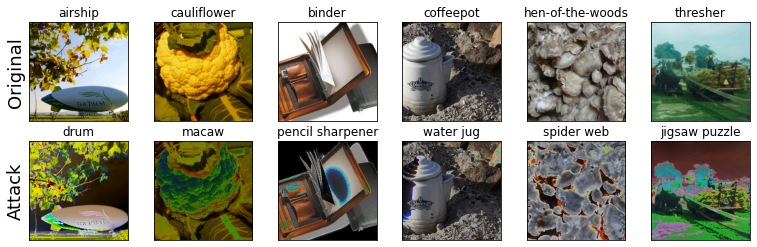

In [89]:
fig, axes = plt.subplots(2, 6, figsize=(13, 4))

for ax_col, idx in zip(axes.T, [1,18,19,29,5,6]):

    for ax, img, label in zip(ax_col, [bx[idx], x_aug[idx]], [get_label(pred_norm[idx]), get_label(pred_aug[idx])]):
        ax.imshow(img.squeeze().permute(1, 2, 0).detach().cpu().numpy())
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis('off')
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)

            
axes[0, 0].set_ylabel("Original", fontsize=18)
axes[1, 0].set_ylabel("Attack", fontsize=18)
plt.savefig('output/solarization_attack.pdf', bbox_inches='tight', pad_inches=0)